In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
from scipy.signal import convolve2d

from tf_hog import tf_hog_descriptor

from PIL import Image
%matplotlib inline

plt.rcParams['image.cmap'] = 'viridis'

In [2]:
def read_images(folder):
    fnames = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    images = [np.array(Image.open(os.path.join(folder, f))) for f in fnames]
    return np.array(images)

data = read_images('cifar/')

In [3]:
import time

tf.reset_default_graph()
init_op = tf.initialize_all_variables()
X = np.repeat(np.repeat(data[:1000], 4, axis=1), 2, axis=2)

t1 = time.time()
hog = tf_hog_descriptor(X)
with tf.Session() as sess:
    summary_writer = tf.train.SummaryWriter('tf_logs/', sess.graph)
    sess.run(init_op)
    t2 = time.time()
    g = hog.eval()
    print(g.shape)
t3 = time.time()

print('Total time: %.3f sec' % (t3 - t1))
print('Session management time: %.3f sec' % (t2 - t1))
print('Evaluation time: %.3f' % (t3 - t2))

(1000, 3780)
Total time: 45.812 sec
Session management time: 3.003 sec
Evaluation time: 42.809


In [12]:
1000 / 42

23.80952380952381

In [11]:
import cv2

img = cv2.imread("cifar/535.png")
hog = cv2.HOGDescriptor()
#h = hog.compute(img)
cv2.imshow('frame', img)

In [91]:
cell_size = 16
block_size = 16
n_bins = 9

a = tf.constant(np.floor(X[:,:,:,:1] / 256 * n_bins), dtype=np.int32) 
b = tf.constant(np.ones(a.get_shape()), dtype=np.float32)
c = tf.space_to_depth(a, cell_size)
d = tf.space_to_depth(b, cell_size)

e = tf.transpose(tf.pack([tf.reduce_sum(tf.to_float(tf.equal(c, i)) * d, 3) for i in range(n_bins)]), [1,2,3,0])

init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init_op)
    z = e.eval()
    
    """
    plt.subplot(2,2,1)
    plt.imshow(z[0,0,0].reshape((cell_size,cell_size)), interpolation='nearest')
    
    plt.subplot(2,2,2)
    plt.imshow(z[0,0,1].reshape((cell_size,cell_size)), interpolation='nearest')
    
    plt.subplot(2,2,3)
    plt.imshow(z[0,1,0].reshape((cell_size,cell_size)), interpolation='nearest')
    
    plt.subplot(2,2,4)
    plt.imshow(z[0,1,1].reshape((cell_size,cell_size)), interpolation='nearest')
    """
    
    print(z.shape)

(10, 2, 2, 9)


In [3]:
def hog_tensor_fold(img, block_size = 16, cell_size = 8, stride = 8):    
    size_t   = a.dtype.itemsize    
    n_block  = block_size
    n_cell   = cell_size
    n_stride = stride
    n_batch, n_height, n_width, n_channel = img.shape
    
    if (n_width - n_block) % n_stride != 0:
        raise ValueError("`img.shape[2] - block_size` must be a multiple of `stride`")
    if (n_height - n_block) % n_stride != 0:
        raise ValueError("`img.shape[1] - block_size` must be a multiple of `stride`")
    if n_block % n_cell != 0:
        raise ValueError("`block_size` must be a multiple of `cell_size`")
    
    strides = ( n_channel * n_height * n_width * size_t, # batch dimension
                n_channel * n_stride * n_width * size_t, # block Y dimension   within an image
                n_channel * n_stride * size_t,           # block X dimension   within an image
                n_channel * n_cell * n_width * size_t,   # cell Y dimension    within a block
                n_channel * n_cell * size_t,             # cell X dimension    within a block
                n_channel * n_width  * size_t,           # spatial Y dimension within a cell
                n_channel * size_t,                      # spatial X dimension within a cell
                size_t )                                 # channel dimension
    
    shape   = ( n_batch, 
               (n_height - n_block) // n_stride + 1, 
                n_width // n_stride, 
                n_block // n_cell, 
                n_block // n_cell, 
                n_cell,
                n_cell,
                n_channel )
    
    result = as_strided(img, strides=strides, shape=shape)
    result = result[:, :, :(n_width - n_block)//n_stride + 1, :, :, :]
    result = result.reshape((result.shape[0],
                             result.shape[1]*result.shape[2],
                             result.shape[3]*result.shape[4],
                             result.shape[5],
                             result.shape[6],
                             result.shape[7]))
    
    return result

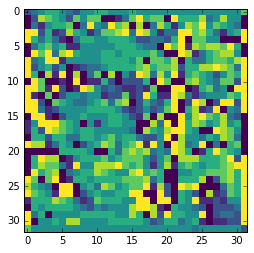

In [213]:
# numpy code

grayscale = False
oriented = False
n_bins = 9

k = 6
X = data[:10]
kernel = np.array([[1,0,-1]])

if grayscale:
    img = X[k].mean(axis=2)    
    gx = convolve2d(img, kernel,   mode = 'same')
    gy = convolve2d(img, kernel.T, mode = 'same')   
    g_mag = np.sqrt(gx**2 + gy**2)
    
else:
    img = X[k]
    gx = np.stack([convolve2d(img[:,:,0], kernel,   mode = 'same'),
                   convolve2d(img[:,:,1], kernel,   mode = 'same'),
                   convolve2d(img[:,:,2], kernel,   mode = 'same')], axis=-1)
    
    gy = np.stack([convolve2d(img[:,:,0], kernel.T, mode = 'same'),
                   convolve2d(img[:,:,1], kernel.T, mode = 'same'),
                   convolve2d(img[:,:,2], kernel.T, mode = 'same')], axis=-1)
    
    g_mag = np.sqrt(gx**2 + gy**2)
    ch_idx = np.argmax(g_mag, axis = 2)
    row_idx, col_idx = np.indices((g_mag.shape[0], g_mag.shape[1]))
    
    gx = gx[row_idx, col_idx, ch_idx]
    gy = gy[row_idx, col_idx, ch_idx]
    g_mag = g_mag[row_idx, col_idx, ch_idx]

g_dir = np.arctan2(gy, gx)
if oriented:
    g_dir += np.pi
    g_bin = np.floor(g_dir / np.pi * n_bins * 0.4999999)
else:
    g_dir[g_dir < 0] += np.pi
    g_bin = np.floor(g_dir / np.pi * n_bins * 0.99999)
    
g_bin = g_bin.reshape(g_bin.shape[0], g_bin.shape[1], -1)

plt.imshow(g_bin[:,:,0], interpolation='nearest')

In [ ]:
Z.shape

In [ ]:
X[0,:,:,0]